In [3]:
import sys
from google.colab import drive

drive.mount('/content/drive')
sys.path.append(r"/content/drive/MyDrive/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
import sys, os, json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.axes import Axes

sns.set()


In [26]:
# import the necessary packages
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from loader_util.preprocessing import ImageToArrayPreprocessor, AspectAwarePreprocessor
from loader_util.datasets import SimpleDatasetLoader
from loader_util.nn.conv import FCHeadNet
from loader_util.callbacks import EpochCheckpoint, TrainingMonitor
##
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, load_model

In [27]:
# script constants
dataset_path = r"/content/drive/MyDrive/ImageDataset/book2/flowers17/images"
model_output_path = r"/content/drive/MyDrive/ImageDataset/book2/flowers17/model"

In [28]:
# construct the data augmenter
aug = ImageDataGenerator(rotation_range=30,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         shear_range=0.2,
                         zoom_range=0.2,
                         horizontal_flip=True,
                         fill_mode="nearest")

In [9]:
print(f"[INFO] loading images......")
image_paths = list(paths.list_images(dataset_path))

# init the preprocessors
aap = AspectAwarePreprocessor(width=224, height=224)
iap = ImageToArrayPreprocessor()

# load dataset from disk, and scale raw pixels
sdl = SimpleDatasetLoader(preprocessors=[aap, iap])
data, labels = sdl.load(image_paths=image_paths, verbose=500)
data = data.astype("float") / 255.0
class_names = np.unique(labels)
class_names

[INFO] loading images......
[INFO] processed 500/1360
[INFO] processed 1000/1360


array(['bluebell', 'buttercup', 'coltsfoot', 'cowslip', 'crocus',
       'daffodil', 'daisy', 'dandelion', 'fritillary', 'iris',
       'lilyvalley', 'pansy', 'snowdrop', 'sunflower', 'tigerlily',
       'tulip', 'windflower'], dtype='<U10')

In [12]:
# train test split the data
trainx, testx, trainy, testy = train_test_split(data, labels,
                                                random_state=42,
                                                test_size=0.25)

In [18]:
# encode the labels
lb = LabelBinarizer()
trainy_encoded = lb.fit_transform(trainy)
testy_encoded = lb.transform(testy)

In [30]:
# create the base model
base_model = VGG16(weights="imagenet",
                   include_top=False,
                   input_shape=(224, 224, 3))

head_model = FCHeadNet.build(base_model=base_model,
                             classes=len(class_names),
                             dense_nodes=256)
model = Model(inputs=base_model.input, outputs=head_model)

In [31]:
# freeze the base model
for layer in base_model.layers:
    layer.trainable = False

In [32]:
print(f"[INFO] compiling the model......")
opt = RMSprop(learning_rate=0.001)
model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=['accuracy'])

[INFO] compiling the model......


In [33]:
print(f"[INFO] training head......")
H = model.fit_generator(aug.flow(trainx, trainy_encoded, batch_size=32),
                    validation_data=(testx, testy_encoded),
                    epochs=25,
                    steps_per_epoch=len(trainx) // 32,
                    verbose=1)

[INFO] training head......


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/25
31/31 [==============================] - 11s 331ms/step - loss: 4.7024 - accuracy: 0.1751 - val_loss: 1.9613 - val_accuracy: 0.3853
Epoch 2/25
31/31 [==============================] - 10s 320ms/step - loss: 2.3378 - accuracy: 0.2864 - val_loss: 1.6984 - val_accuracy: 0.4824
Epoch 3/25
31/31 [==============================] - 10s 321ms/step - loss: 2.0034 - accuracy: 0.3836 - val_loss: 1.3245 - val_accuracy: 0.6235
Epoch 4/25
31/31 [==============================] - 10s 321ms/step - loss: 1.8463 - accuracy: 0.4261 - val_loss: 1.2084 - val_accuracy: 0.6324
Epoch 5/25
31/31 [==============================] - 10s 320ms/step - loss: 1.4852 - accuracy: 0.5324 - val_loss: 0.8678 - val_accuracy: 0.7588
Epoch 6/25
31/31 [==============================] - 10s 321ms/step - loss: 1.3910 - accuracy: 0.5577 - val_loss: 0.6980 - val_accuracy: 0.8088
Epoch 7/25
31/31 [==============================] - 10s 322ms/step - loss: 1.3350 - accuracy: 0.5840 - val_loss: 0.7266 - val_accuracy: 0.7676

In [34]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testx, batch_size=32)
print(classification_report(testy_encoded.argmax(axis=1),
                            predictions.argmax(axis=1), target_names=class_names))

[INFO] evaluating network...
11/11 [==============================] - 0s 26ms/step
              precision    recall  f1-score   support

    bluebell       0.81      0.85      0.83        20
   buttercup       0.90      0.90      0.90        20
   coltsfoot       0.74      0.88      0.80        16
     cowslip       0.82      0.74      0.78        19
      crocus       0.93      0.87      0.90        15
    daffodil       0.94      0.85      0.89        20
       daisy       1.00      0.91      0.95        23
   dandelion       0.96      0.85      0.90        27
  fritillary       0.90      1.00      0.95        19
        iris       0.95      0.95      0.95        21
  lilyvalley       0.89      0.89      0.89        18
       pansy       1.00      1.00      1.00        16
    snowdrop       1.00      0.86      0.93        22
   sunflower       1.00      0.96      0.98        23
   tigerlily       1.00      1.00      1.00        18
       tulip       0.86      0.90      0.88        2

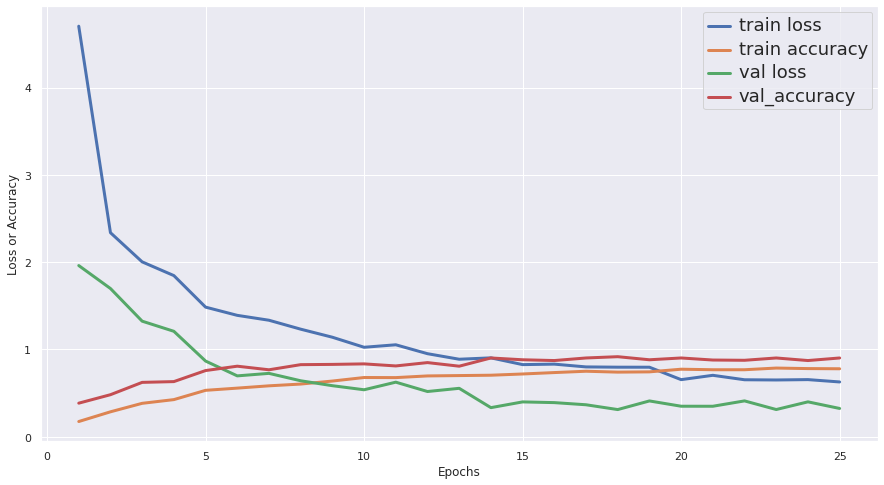

In [36]:
# plot the performance
epochs = range(1,25+1)
loss = H.history['loss']
accuracy = H.history['accuracy']
val_loss = H.history['val_loss']
val_accuracy = H.history['val_accuracy']
plot_df = pd.DataFrame(data=np.c_[epochs,loss,accuracy,val_loss,val_accuracy], 
                       columns=['epochs','loss', 'accuracy', 'val_loss', 'val_accuracy'])

# do the actual plots
sns.set(font_scale=1)
f, ax = plt.subplots(1, 1, figsize=(15,8))
sns.lineplot(data=plot_df, x='epochs', y='loss', ax=ax, label='train loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='accuracy', ax=ax, label='train accuracy', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_loss', ax=ax, label='val loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_accuracy', ax=ax, label='val_accuracy', linewidth=3)
ax.set_ylabel('Loss or Accuracy')
ax.set_xlabel('Epochs')
plt.setp(ax.get_legend().get_texts(), fontsize='18');

In [39]:
# train the whole network
# freeze the base model
for layer in base_model.layers[15:]:
    layer.trainable = True

In [40]:
print(f"[INFO] compiling the model......")
opt = SGD(learning_rate=0.001)
model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=['accuracy'])

[INFO] compiling the model......


In [41]:
print(f"[INFO] training head......")
H = model.fit_generator(aug.flow(trainx, trainy_encoded, batch_size=32),
                    validation_data=(testx, testy_encoded),
                    epochs=100,
                    steps_per_epoch=len(trainx) // 32,
                    verbose=1)

[INFO] training head......


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/100
31/31 [==============================] - 12s 325ms/step - loss: 0.3853 - accuracy: 0.8644 - val_loss: 0.2421 - val_accuracy: 0.9294
Epoch 2/100
31/31 [==============================] - 10s 322ms/step - loss: 0.4373 - accuracy: 0.8492 - val_loss: 0.2379 - val_accuracy: 0.9294
Epoch 3/100
31/31 [==============================] - 10s 319ms/step - loss: 0.4151 - accuracy: 0.8522 - val_loss: 0.2584 - val_accuracy: 0.9176
Epoch 4/100
31/31 [==============================] - 10s 320ms/step - loss: 0.4264 - accuracy: 0.8634 - val_loss: 0.2390 - val_accuracy: 0.9294
Epoch 5/100
31/31 [==============================] - 10s 321ms/step - loss: 0.4110 - accuracy: 0.8694 - val_loss: 0.2664 - val_accuracy: 0.9147
Epoch 6/100
31/31 [==============================] - 10s 319ms/step - loss: 0.3906 - accuracy: 0.8674 - val_loss: 0.2391 - val_accuracy: 0.9353
Epoch 7/100
31/31 [==============================] - 10s 320ms/step - loss: 0.3681 - accuracy: 0.8887 - val_loss: 0.2247 - val_accuracy:

In [42]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testx, batch_size=32)
print(classification_report(testy_encoded.argmax(axis=1),
                            predictions.argmax(axis=1), target_names=class_names))

[INFO] evaluating network...
11/11 [==============================] - 0s 27ms/step
              precision    recall  f1-score   support

    bluebell       1.00      0.95      0.97        20
   buttercup       1.00      1.00      1.00        20
   coltsfoot       0.88      0.94      0.91        16
     cowslip       0.83      1.00      0.90        19
      crocus       0.88      0.93      0.90        15
    daffodil       1.00      0.95      0.97        20
       daisy       1.00      0.87      0.93        23
   dandelion       0.96      0.96      0.96        27
  fritillary       1.00      0.95      0.97        19
        iris       1.00      1.00      1.00        21
  lilyvalley       1.00      0.89      0.94        18
       pansy       1.00      1.00      1.00        16
    snowdrop       0.95      0.95      0.95        22
   sunflower       1.00      1.00      1.00        23
   tigerlily       0.95      1.00      0.97        18
       tulip       1.00      0.95      0.97        2

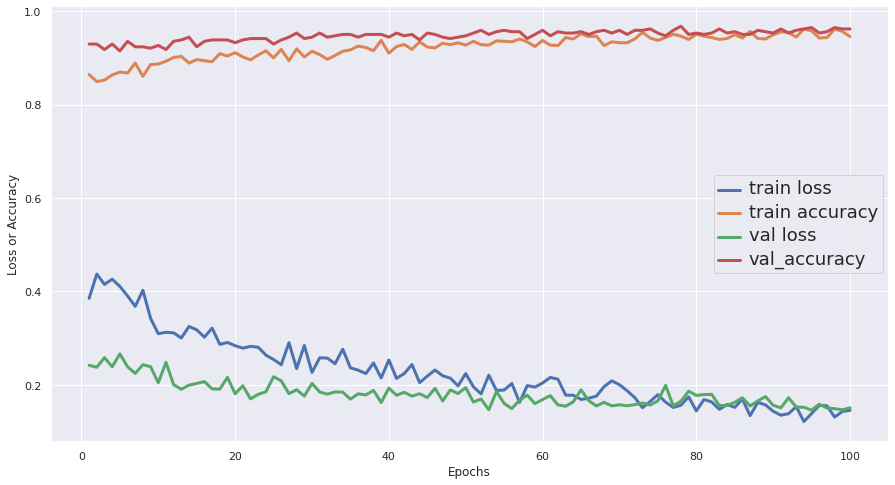

In [43]:
# plot the performance
epochs = range(1,100+1)
loss = H.history['loss']
accuracy = H.history['accuracy']
val_loss = H.history['val_loss']
val_accuracy = H.history['val_accuracy']
plot_df = pd.DataFrame(data=np.c_[epochs,loss,accuracy,val_loss,val_accuracy], 
                       columns=['epochs','loss', 'accuracy', 'val_loss', 'val_accuracy'])

# do the actual plots
sns.set(font_scale=1)
f, ax = plt.subplots(1, 1, figsize=(15,8))
sns.lineplot(data=plot_df, x='epochs', y='loss', ax=ax, label='train loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='accuracy', ax=ax, label='train accuracy', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_loss', ax=ax, label='val loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_accuracy', ax=ax, label='val_accuracy', linewidth=3)
ax.set_ylabel('Loss or Accuracy')
ax.set_xlabel('Epochs')
plt.setp(ax.get_legend().get_texts(), fontsize='18');